In [1]:
# Optimization for Machine Learning
# Problem: projected gradient descent for SVM

%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pegasos import *
from cyclic_coordinate_descent import *
from random_coordinate_descent import *
from utils import *
from batchGradient import batchGradient
np.random.seed(1337)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)


### Load mnist training and validation images. Plot examples from both sets and show their corresponding labels as verification.

In [2]:
# mnist load images
train_imgs_dir = './dataset/mnist/train-images.idx3-ubyte'
train_labels_dir = './dataset/mnist/train-labels.idx1-ubyte'
val_imgs_dir = './dataset/mnist/t10k-images.idx3-ubyte'
val_labels_dir = './dataset/mnist/t10k-labels.idx1-ubyte'
train_imgs, train_labels = mnist_data_loader(train_imgs_dir, train_labels_dir)
print("mnist: number of training examples", train_imgs.shape[0])

val_imgs, val_labels = mnist_data_loader(val_imgs_dir, val_labels_dir)
print("mnist: number of validation examples", val_imgs.shape[0])
HEIGHT = 28
WIDTH = 28

# Reshape images to vectors
train_vectors = train_imgs.reshape(-1, HEIGHT * WIDTH)
val_vectors = val_imgs.reshape(-1, HEIGHT * WIDTH)

mnist: number of training examples 11769
mnist: number of validation examples 1932


## Plot Functions

In [3]:
# initialize w, lambda
num_examples, num_features = train_vectors.shape

def error_plot(w, _lambda, img_vectors, labels, algorithm, dilate=1, num_epochs=4, yscale='log'):
    """plot errors"""
    error_list = cal_objective_dilate(w, _lambda, img_vectors, labels, dilate)
    print(algorithm+" error:", error_list[-1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
#     plt.yscale(yscale)
    plt.plot(range(0,num_epochs+1), error_list, **kwargs)

def cal_objective_dilate(w, _lambda, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [objective(x, _lambda, img_vectors, labels) \
                                for x in w[0:num_iters:dilate]]

def acc_plot(w, img_vectors, labels, algorithm, dilate=1, num_epochs=4):
    """plot accuracies"""
    acc_list = cal_acc_dilate(w, img_vectors, labels,  dilate)
    print(algorithm+" acc:", acc_list[-1])
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.plot(range(0,num_epochs+1), acc_list, **kwargs)

def cal_acc_dilate(w, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [compute_accuracy(x, img_vectors, labels) for x in w[0:num_iters:dilate]]

## Training error

In [4]:
def average_weight(w):
    w_sum = np.zeros([num_features,1])
    w_average = []
    for i in range(0,len(w)):
        w_sum += w[i]
        w_average.append(w_sum/(i+1))
    return w_average

def set_pegasos_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = num_examples*4
    return _lambda, num_steps, w0

def set_primal_cyclic_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias

def set_primal_random_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias

# Batch Gradient Descent
BGD_lmbda = 1.0
BGD_model = batchGradient(train_vectors, train_labels, epochs=4, lmbda=BGD_lmbda)
BGD_output_weight, BGD_times = BGD_model.fit()

# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors, train_labels, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors, train_labels)) # print final training error

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors, train_labels))

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors, train_labels))


Batch gradient descent training
Pegasos training starts...
Iterations: 47075    total_time: 17.550097227096558
Pegasos training ends...
Pegasos training error   0.08907559662656098
CCD training starts...
epoch: 0    total_time: 62.67242503166199
epoch: 1    total_time: 119.21617221832275
epoch: 2    total_time: 175.0358908176422
epoch: 3    total_time: 230.8805730342865
CCD training ends...
CCD training error:   0.22502497544730926
RCD training starts...
epoch: 0    total_time: 67.11151814460754
epoch: 1    total_time: 132.76194381713867
epoch: 2    total_time: 194.79401564598083
epoch: 3    total_time: 257.54519629478455
RCD training ends...
RCD training error:   0.11281559114003331


Pegasos error: 0.08907559662656098
CCD error: 0.22502497544730926
RCD error: 0.11281559114003331
BGD error: 0.21302155660291971


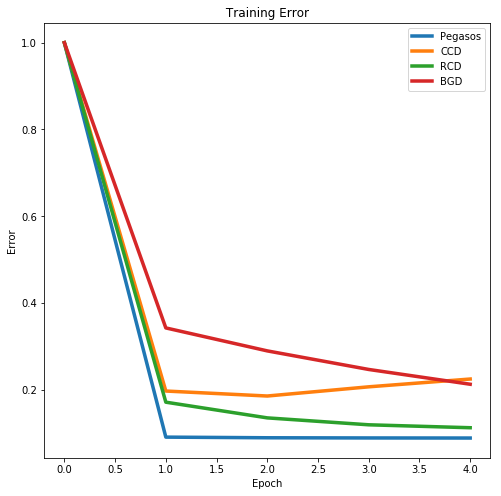

In [5]:
# training error plot
num_epochs = 4
plot_dilation_pegasos = num_examples
plot_dilation_CCD=num_features
plot_dilation_RCD=num_features
plot_dilation_BGD=num_features

plt.figure(figsize=(8, 8))


error_plot(pegasos_output_weight, pegasos_lambda, train_vectors, train_labels, 'Pegasos', plot_dilation_pegasos, num_epochs)
error_plot(primal_cyclic_cd_output_weight, primal_cyclic_cd_lambda, train_vectors, train_labels, 'CCD', plot_dilation_CCD, num_epochs)
error_plot(primal_random_cd_output_weight, primal_random_cd_lambda, train_vectors, train_labels, 'RCD', plot_dilation_RCD, num_epochs)
error_plot(BGD_output_weight, BGD_lmbda, train_vectors, train_labels, 'BGD', 1, num_epochs)

plt.title(' Training Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'BGD'])

Pegasos acc: 0.987169683065681
CCD acc: 0.9703458237743223
RCD acc: 0.9818166369275214
BGD acc: 0.9723850794460022


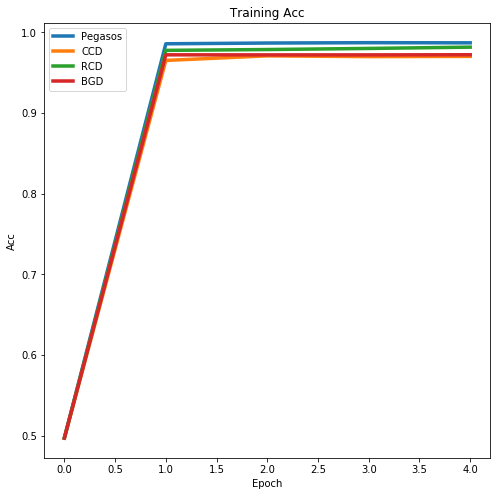

In [6]:
# training acc plot
num_epochs = 4
plot_dilation_pegasos = num_examples
plot_dilation_CCD=num_features
plot_dilation_RCD=num_features

plt.figure(figsize=(8, 8))

acc_plot(pegasos_output_weight, train_vectors, train_labels, 'Pegasos', plot_dilation_pegasos, num_epochs)
acc_plot(primal_cyclic_cd_output_weight, train_vectors, train_labels, 'CCD', plot_dilation_CCD, num_epochs)
acc_plot(primal_random_cd_output_weight, train_vectors, train_labels, 'RCD', plot_dilation_RCD, num_epochs)
acc_plot(BGD_output_weight, train_vectors, train_labels, 'BGD', 1, num_epochs)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'BGD'])

Pegasos error: 0.09381589907257848
CCD error: 0.230263231319296
RCD error: 0.11592436792206458
BGD error: 0.22096635974576057


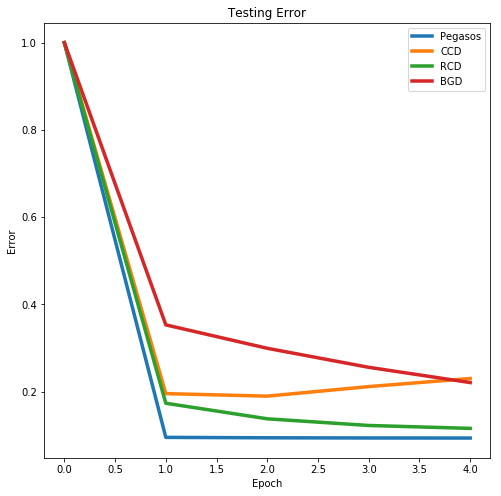

In [7]:
# test error plot
num_epochs = 4
plot_dilation_pegasos = num_examples
plot_dilation_CCD=num_features
plot_dilation_RCD=num_features

plt.figure(figsize=(8, 8))

error_plot(pegasos_output_weight, pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation_pegasos, num_epochs)
error_plot(primal_cyclic_cd_output_weight, primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation_CCD, num_epochs)
error_plot(primal_random_cd_output_weight, primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation_RCD, num_epochs)
error_plot(BGD_output_weight, BGD_lmbda, val_vectors, val_labels, 'BGD', 1, num_epochs)

plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'BGD'])

Pegasos acc: 0.9875776397515528
CCD acc: 0.9653209109730849
RCD acc: 0.9808488612836439
BGD acc: 0.9668737060041408


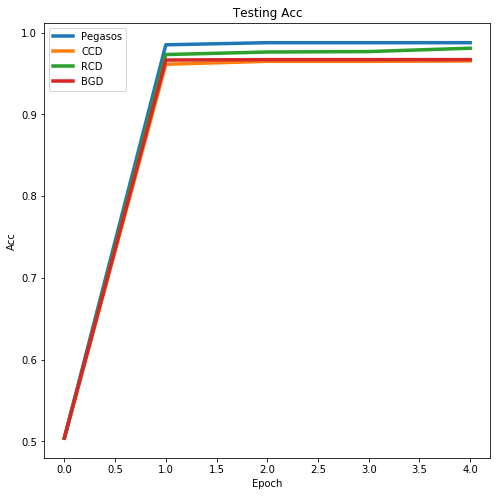

In [8]:
# test acc plot
num_epochs = 4
plot_dilation_pegasos = num_examples
plot_dilation_CCD=num_features
plot_dilation_RCD=num_features

plt.figure(figsize=(8, 8))

acc_plot(pegasos_output_weight, val_vectors, val_labels, 'Pegasos', plot_dilation_pegasos, num_epochs)
acc_plot(primal_cyclic_cd_output_weight, val_vectors, val_labels, 'CCD', plot_dilation_CCD, num_epochs)
acc_plot(primal_random_cd_output_weight, val_vectors, val_labels, 'RCD', plot_dilation_RCD, num_epochs)
acc_plot(BGD_output_weight, val_vectors, val_labels, 'BGD', 1, num_epochs)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'BGD'])